# Process recount2 data
This notebook does the following:

1. Select template experiment. This template experiment will be used in the next [notebook](2_identify_generic_genes_pathways.ipynb) to simulate experiments with the same experimental design but testing a different biological process.


2. Uses pre-downloaded data from [notebook]()

3. Normalizes data using MRnorm
Check what the distribution looks like

4. Train VAE on recount2 data

In [1]:
%load_ext autoreload
%load_ext rpy2.ipython
%autoreload 2
import os
import pandas as pd
import seaborn as sns
from ponyo import utils, train_vae_modules
from generic_expression_patterns_modules import process

Using TensorFlow backend.
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
# Set seeds to get reproducible VAE trained models
process.set_all_seeds()

### Set parameters for data processing

Most parameters are read from `config_filename`. We manually selected bioproject [SRP012656](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE37764) as the template experiment, which contains primary non-small cell lung adenocarcinoma tumors and adjacent normal tissues of 6 never-smoker Korean female patients with 2 replicates each.

In [3]:
base_dir = os.path.abspath(os.path.join(os.getcwd(), "../"))

# Read in config variables
config_filename = os.path.abspath(
    os.path.join(base_dir, "configs", "config_human_general_MRnorm.tsv")
)

params = utils.read_config(config_filename)

local_dir = params["local_dir"]
dataset_name = params["dataset_name"]

# File that contains gene ranks identified by Crow et. al.
DE_prior_filename = params["reference_gene_filename"]

# Template experiment ID
project_id = params["project_id"]

# Output files of recount2 template experiment data
# processed_template_filename = params["processed_template_filename"]

# Output files of recount2 compendium data
normalized_compendium_filename = params["normalized_compendium_filename"]

# Output file: pickled scaler (generated during compendium normalization)
scaler_filename = params["scaler_filename"]

### Load template data file

In [4]:
mapped_template_filename = params["mapped_template_filename"]

In [5]:
mapped_template = pd.read_csv(mapped_template_filename, sep="\t", index_col=0, header=0)
mapped_template.head()

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A4GALT,A4GNT,AAAS,AACS,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
SRR493937,244,396,6,144077,2089,7,946,7,941,752,...,214,161,202,569,1618,9,768,12758,5060,773
SRR493938,230,384,8,142807,2062,8,968,3,978,776,...,219,171,215,576,1655,7,808,12925,5061,783
SRR493939,308,396,11,77651,1064,4,321,2,1633,1518,...,345,372,198,387,1315,30,842,4339,3304,743
SRR493940,303,351,13,77739,1125,12,325,0,1637,1481,...,318,317,155,448,1322,36,795,4400,3308,714
SRR493941,203,327,0,235645,2438,6,945,15,1520,1027,...,191,71,240,533,2006,4,1331,14318,4776,936


### Load recount2

In [6]:
mapped_compendium_filename = params["mapped_compendium_filename"]

In [7]:
# mapped_compendium = pd.read_csv(mapped_compendium_filename, sep="\t", index_col=0, header=0)

### MR normalize

In [8]:
metadata = pd.DataFrame(
    data=[i for i in range(mapped_template.shape[0])],
    index=mapped_template.index,
    columns=["group"],
)
metadata.head()

,group
SRR493937,0
SRR493938,1
SRR493939,2
SRR493940,3
SRR493941,4


In [9]:
metadata_filename = os.path.join(
    base_dir, dataset_name, "data", "metadata", "MRnorm_metadata.tsv"
)
metadata.to_csv(metadata_filename, sep="\t")

In [10]:
%%R -i base_dir -i mapped_template_filename -i metadata_filename -i normalized_compendium_filename -i scaler_filename

source(paste0(base_dir, '/generic_expression_patterns_modules/normalize_counts.R'))

MRnorm_expression(mapped_template_filename, metadata_filename, normalized_compendium_filename, scaler_filename)

R[write to console]: Loading required package: S4Vectors

R[write to console]: Loading required package: stats4

R[write to console]: Loading required package: BiocGenerics

R[write to console]: Loading required package: parallel

R[write to console]: 
Attaching package: ‘BiocGenerics’


R[write to console]: The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


R[write to console]: The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


R[write to console]: The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, 

[1] "Checking sample ordering..."
[1] TRUE


R[write to console]:   the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

R[write to console]:   the design formula contains one or more numeric variables that have mean or
  standard deviation larger than 5 (an arbitrary threshold to trigger this message).
  it is generally a good idea to center and scale numeric variables in the design
  to improve GLM convergence.



In [11]:
# Read in MR normalized data
MRnorm_expression_data = pd.read_csv(
    normalized_compendium_filename, sep="\t", index_col=0, header=0
)

In [15]:
scale_factor = pd.read_csv(scaler_filename, sep="\t", index_col=0, header=0)

In [16]:
scale_factor

,x
SRR493937,4.663753
SRR493938,4.661516
SRR493939,5.082834
SRR493940,5.089834
SRR493941,5.087308
SRR493942,5.089441
SRR493943,5.035682
SRR493944,5.018968
SRR493945,4.600965
SRR493946,4.596884


In [12]:
MRnorm_expression_data.head()

,SRR493937,SRR493938,SRR493939,SRR493940,SRR493941,SRR493942,SRR493943,SRR493944,SRR493945,SRR493946,...,SRR493963,SRR493964,SRR493965,SRR493966,SRR493967,SRR493968,SRR493969,SRR493970,SRR493971,SRR493972
A1BG,52.318376,49.340176,60.596118,59.530434,39.903223,42.244328,19.659702,21.319123,56.944572,62.868668,...,35.126909,0.000000,0.000000,44.832563,0.000000,0.000000,0.000000,39.583775,53.13753,164.600427
A1BG.AS1,84.910151,82.376642,77.909294,68.960997,64.277605,63.464734,36.936410,38.254874,94.110686,89.190843,...,0.000000,102.463630,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,65.840171
A1CF,1.286517,1.716180,2.164147,2.554111,0.000000,0.000000,1.985829,0.796977,0.000000,0.217539,...,0.000000,0.000000,70.571730,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,115.220299
A2M,30892.928865,30635.315574,15277.107586,15273.387417,46320.171782,46178.355332,14227.865520,14111.864461,41037.040616,41132.206553,...,5831.066932,8760.640391,17266.549951,10737.398914,6897.540924,6221.448332,6215.733137,3404.204644,17455.67862,2501.926485
A2M.AS1,447.922489,442.345408,209.332043,221.028838,479.231805,473.922412,190.838120,192.270592,797.876045,805.110516,...,421.522911,845.324950,658.669480,448.325633,571.816864,387.565634,537.899983,158.335100,371.96271,49.380128


/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


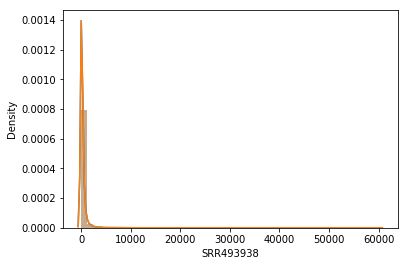

In [21]:
sns.distplot(MRnorm_expression_data["SRR493937"])
sns.distplot(MRnorm_expression_data["SRR493938"])

In [ ]:
# Check that we're normalizing by gene
# Check that dist looks similar across genes
# Determine how to re-scale using size factors
# May need to do a hack job for ponyo

### Train VAE
Performed exploratory analysis of compendium data [here](../explore_data/viz_recount2_compendium.ipynb) to help interpret loss curve.

In [13]:
"""# Create VAE directories if needed
output_dirs = [
    os.path.join(base_dir, dataset_name, "models"),
    os.path.join(base_dir, dataset_name, "logs"),
]

NN_architecture = params["NN_architecture"]

# Check if NN architecture directory exist otherwise create
for each_dir in output_dirs:
    sub_dir = os.path.join(each_dir, NN_architecture)
    os.makedirs(sub_dir, exist_ok=True)"""

'# Create VAE directories if needed\noutput_dirs = [\n    os.path.join(base_dir, dataset_name, "models"),\n    os.path.join(base_dir, dataset_name, "logs"),\n]\n\nNN_architecture = params["NN_architecture"]\n\n# Check if NN architecture directory exist otherwise create\nfor each_dir in output_dirs:\n    sub_dir = os.path.join(each_dir, NN_architecture)\n    os.makedirs(sub_dir, exist_ok=True)'

In [14]:
# Train VAE on new compendium data
# train_vae_modules.train_vae(config_filename, normalized_compendium_filename)